In [1]:
! pip install qiskit-aqua

In [2]:
! pip install openpyxl

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

from qiskit import BasicAer
from qiskit.circuit.library import ZZFeatureMap, PauliFeatureMap
from qiskit.aqua import QuantumInstance, aqua_globals
from qiskit.aqua.algorithms import QSVM
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name

seed = 10599
aqua_globals.random_seed = seed
import warnings
warnings.filterwarnings('ignore')

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/tmp/ipykernel_8135/3458627689.py:13: DeprecationWarning: The variable qiskit.aqua.aqua_globals is deprecated. It was moved/refactored to qiskit.utils.algorithm_globals (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  aqua_globals.random_seed = seed


In [4]:
from qiskit.aqua.components.optimizers import COBYLA
from qiskit.aqua.components.feature_maps import RawFeatureVector
from qiskit.circuit.library import TwoLocal
import functools

In [5]:
c_dataset = pd.read_excel('co1_attainment_c_theory.xlsx', engine='openpyxl')

c_dataset.head()

,S.NO,REGISTER NO.,NAMES,MS 1 20%,MS 2 40%,MS 3 60%,ASSIGNMENT 40%,SEM RESULT 34%,TOTAL 194%,OBTAINED FOR 100,Y OR N,Threshold 60%
0,1,15 51 001,AARTHI.P.,13.6,36.8,0,40,30.6,121.0,62.371134,Y,Y
1,2,15 51 002,ABDUL KHADI.K.,7.2,7.2,0,40,8.5,62.9,32.422680,N,N
2,3,15 51 003,ABINAYA.N.,15.6,32.0,0,40,30.6,118.2,60.927835,Y,Y
3,4,15 51 004,AKALYA.M.,10.0,8.8,0,40,20.4,79.2,40.824742,N,N
4,5,15 51 005,ARCHANADEVI@KAMATCHI R.,14.4,30.4,0,40,27.2,112.0,57.731959,Y,N


In [6]:
df = c_dataset.copy()
df.drop(['MS 3 60%', 'Threshold 60%'], axis=1, inplace=True)
df['Y OR N'].replace(to_replace=['Y', 'N'], value=[1, 0], inplace=True)
df.drop(['S.NO', 'REGISTER NO.','NAMES', 'ASSIGNMENT 40%'], axis=1,inplace = True)
df.head()

,MS 1 20%,MS 2 40%,SEM RESULT 34%,TOTAL 194%,OBTAINED FOR 100,Y OR N
0,13.6,36.8,30.6,121.0,62.371134,1
1,7.2,7.2,8.5,62.9,32.422680,0
2,15.6,32.0,30.6,118.2,60.927835,1
3,10.0,8.8,20.4,79.2,40.824742,0
4,14.4,30.4,27.2,112.0,57.731959,1


<AxesSubplot:>

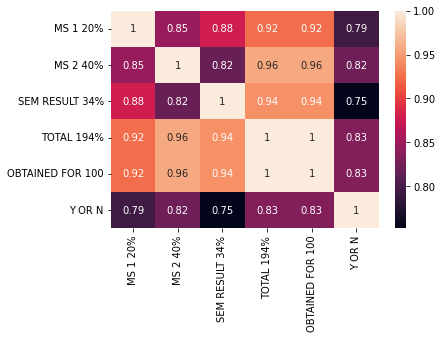

In [7]:
import seaborn as sns
corr = df.corr()
sns.heatmap(corr, annot = True)

In [8]:
df.drop(['MS 1 20%','MS 2 40%'], axis = 1, inplace = True)
df.columns

Index(['SEM RESULT 34%', 'TOTAL 194%', 'OBTAINED FOR 100', 'Y OR N'], dtype='object')

In [9]:
vals =df[df.columns[:-1]].values

In [10]:
def custom_data_map_func(x):
    """Define a function map from R^n to R.
    
    Args:
        x (np.ndarray): data
    Returns:
        double: the mapped value
    """
    coeff = x[0] if len(x) == 1 else functools.reduce(lambda m, n: m * n, np.pi - x)
    return coeff

In [11]:
train_input = vals[:25]
test_input = vals[25:]

training_data = {1:[],0:[]} # 1 == 'A' and 0 == 'B'
for i in range(len(train_input)):
    if df['Y OR N'][i] == 1:
        training_data[1].append(train_input[i].tolist())
    else:
        training_data[0].append(train_input[i].tolist())
        
testing_data = {1:[],0:[]} # 1 == 'A' and 0 == 'B'
for i in range(len(test_input)):
    if df['Y OR N'][i] == 1:
        testing_data[1].append(test_input[i].tolist())
    else:
        testing_data[0].append(test_input[i].tolist())

In [12]:
def qsvm_testing_accuracy(training_data, testing_data, feature_dim, reps, entanglement):
    feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=reps, entanglement=entanglement,  data_map_func=custom_data_map_func)
    
    qsvm = QSVM(feature_map, training_data, testing_data)

    backend = BasicAer.get_backend('qasm_simulator')
    quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)
    result = qsvm.run(quantum_instance)
    print('Testing Accuracy for reps={} and entanglement={}: '.format(reps, entanglement), result['testing_accuracy'])
    return

In [13]:
lst = ['linear', 'circular', 'full']

feature_dim = 3

for i in range(len(lst)):
    for j in lst:
        qsvm_testing_accuracy(training_data, testing_data, feature_dim, i+1, j)


Testing Accuracy for reps=1 and entanglement=linear:  0.5625
Testing Accuracy for reps=1 and entanglement=circular:  0.8125
Testing Accuracy for reps=1 and entanglement=full:  0.8125
Testing Accuracy for reps=2 and entanglement=linear:  0.6875
Testing Accuracy for reps=2 and entanglement=circular:  0.875
Testing Accuracy for reps=2 and entanglement=full:  0.875
Testing Accuracy for reps=3 and entanglement=linear:  0.6875
Testing Accuracy for reps=3 and entanglement=circular:  0.6875
Testing Accuracy for reps=3 and entanglement=full:  0.6875


In [29]:
reps = 2
entanglement = 'circular'
feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=reps, entanglement=entanglement,  data_map_func=custom_data_map_func)
    
final_qsvm = QSVM(feature_map, training_data, testing_data)

backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)
result = final_qsvm.run(quantum_instance)
result['testing_accuracy']

0.875